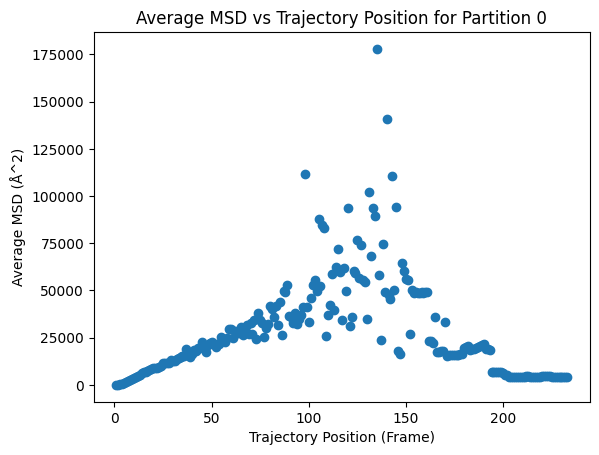

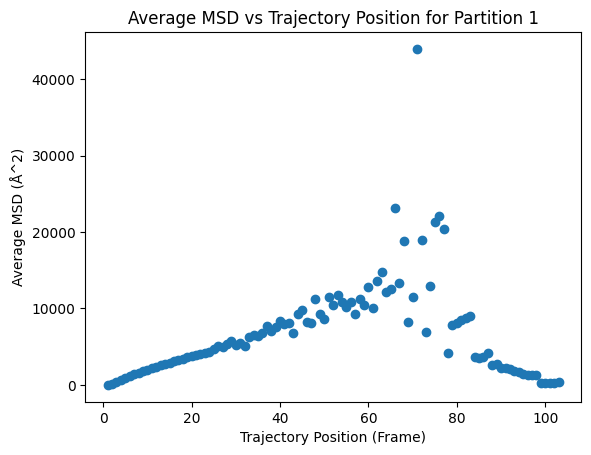

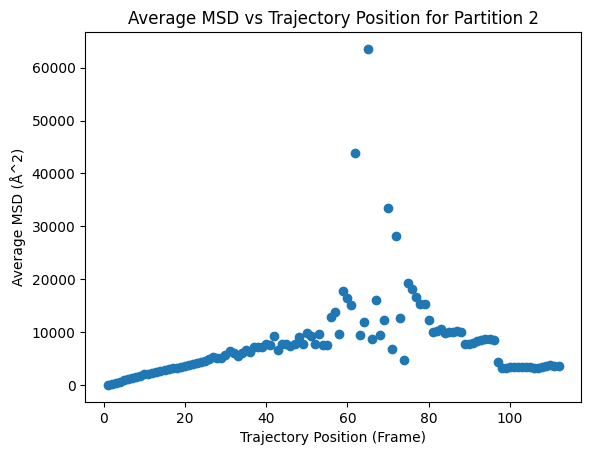

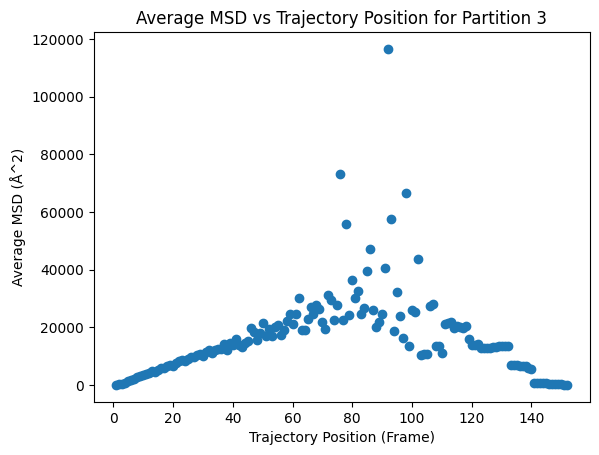

In [2]:
import MDAnalysis as mda
import matplotlib.pyplot as plt
import numpy as np

# File paths
graphite_water_psf = r'D:\all_programming\MSD\data_files\unwrapped\graphite_water.psf'
graphite_trajectory_dcd = r'D:\all_programming\MSD\data_files\unwrapped\output_per_20ps.dcd'

# Load the universe
global_uni = mda.Universe(graphite_water_psf, graphite_trajectory_dcd)
Oxg_uni = global_uni.select_atoms('resname SPCE and name OW')

# Determine partitions
z_maxs = [max(Oxg_uni.positions[:, 2]) for _ in global_uni.trajectory]
average_z_max = sum(z_maxs) / len(z_maxs)
partition_count = 4
z_partitions = [average_z_max / partition_count * (i + 1) for i in range(partition_count)]

def calculate_msd(position_dict):
    x_vals = np.array(position_dict['x_vals'])
    y_vals = np.array(position_dict['y_vals'])
    z_vals = np.array(position_dict['z_vals'])
    num_points = len(x_vals)
    msd = np.zeros(num_points)
    for dt in range(1, num_points):
        displacements = np.square(x_vals[dt:] - x_vals[:-dt]) + np.square(y_vals[dt:] - y_vals[:-dt]) + np.square(z_vals[dt:] - z_vals[:-dt])
        msd[dt] = np.mean(displacements)
    return msd

msd_dict = {atom_num: {i: [] for i in range(len(z_partitions))} for atom_num in range(len(Oxg_uni))}

for atom_num in range(len(Oxg_uni)):
    atom_part_movement = []
    atom_pos = {'x_vals': [], 'y_vals': [], 'z_vals': []}
    for frame in global_uni.trajectory:
        current_z = Oxg_uni.positions[atom_num][2]
        partition = next((i for i, z in enumerate(z_partitions) if current_z < z), len(z_partitions) - 1)
        atom_part_movement.append(partition)
        atom_pos['x_vals'].append(Oxg_uni.positions[atom_num][0])
        atom_pos['y_vals'].append(Oxg_uni.positions[atom_num][1])
        atom_pos['z_vals'].append(current_z)
    
    atom_n_switch_and_pos = {}
    ticker = -1
    for i in range(len(atom_pos['z_vals'])):
        if i == 0 or atom_part_movement[i - 1] != atom_part_movement[i]:
            ticker += 1
            atom_n_switch_and_pos[ticker] = {'location': atom_part_movement[i], 'x_vals': [], 'y_vals': [], 'z_vals': []}
        atom_n_switch_and_pos[ticker]['x_vals'].append(atom_pos['x_vals'][i])
        atom_n_switch_and_pos[ticker]['y_vals'].append(atom_pos['y_vals'][i])
        atom_n_switch_and_pos[ticker]['z_vals'].append(atom_pos['z_vals'][i])
    
    for key in atom_n_switch_and_pos.keys():
        msd_array = calculate_msd(atom_n_switch_and_pos[key])
        msd_dict[atom_num][atom_n_switch_and_pos[key]['location']].append(msd_array)

def matrix_addition(array1, array2):
    if len(array1) > len(array2):
        array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
    else:
        array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
    return array1 + array2

partition_msd = {i: [] for i in range(len(z_partitions))}
for atom in msd_dict.keys():
    for i in range(len(z_partitions)):
        partition_msd[i] += msd_dict[atom][i]

part_lengths = {partition: [len(item) for item in partition_msd[partition]] for partition in partition_msd}
average_dict = {key: {length: count for length, count in zip(sorted(set(lengths)), [lengths.count(length) for length in sorted(set(lengths))])} for key, lengths in part_lengths.items()}
longest_ar_dict = {key: max(lengths) for key, lengths in part_lengths.items()}
averaged_msd = {key: np.zeros(length) for key, length in longest_ar_dict.items()}

for key in partition_msd:
    for matrix in partition_msd[key]:
        averaged_msd[key] = matrix_addition(averaged_msd[key], matrix)

division_to_key = {}
for part in range(len(z_partitions)):
    division_to_key[part] = {}
    for i in range(len(average_dict[part].keys())):
        try:
            carkeys = average_dict[part].keys()
            first_key = list(carkeys)[-(i + 1)]
            prior_key = list(carkeys)[-(i + 2)]
            first_value = average_dict[part][first_key]
            delta = first_key - prior_key
            for j in range(delta):
                division_to_key[part][first_key - j] = first_value
        except IndexError:
            division_to_key[part][1] = average_dict[part][1]

def reverse_secondary_indexes(sub_dict):
    return {key: sub_dict[key] for key in sorted(sub_dict)}

division_to_key = {key: reverse_secondary_indexes(division_to_key[key]) for key in division_to_key}

final_msd = {part: {key: averaged_msd[part][key - 1] / division_to_key[part][key] for key in division_to_key[part]} for part in range(len(z_partitions))}

final_final_msd = {part: [final_msd[part][key] for key in final_msd[part]] for part in final_msd}
final_list_vals = {part: list(final_msd[part].keys()) for part in final_msd}

for i in range(len(z_partitions)):
    x_vals = final_list_vals[i]
    y_vals = final_final_msd[i]
    plt.scatter(x_vals, y_vals)
    plt.xlabel('Trajectory Position (Frame)')
    plt.ylabel('Average MSD (Å^2)')
    plt.title(f'Average MSD vs Trajectory Position for Partition {i}')
    plt.show()
